# Visualisations 

In [6]:
import math
from typing import List

import scipy
import scipy.sparse
from sklearn.neighbors import NearestNeighbors
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

### Kernel Visualisation

In [4]:
# KERNELS
def rbf(distance, variance):
    return math.exp(- (distance**2) / (2 * variance))

def laplacian(distance,variance):
    return math.exp(- (distance) / (math.sqrt(variance)))



def sigmoid_kernel(x, y, gamma: float = 1.0, coef0: float = 0.0) -> float:
    # Needs γ and c inside 'nice' ranges to stay in the valid kernel regime.
    x, y = np.asarray(x), np.asarray(y)
    return math.tanh(gamma * float(np.dot(x, y)) + coef0)

def chi2(distance, gamma):
    # Implemented using distance instead of vectors
    return math.exp(-gamma * distance)


# need to access the actual neighbours for these below

# Cosine 
# Polynomial

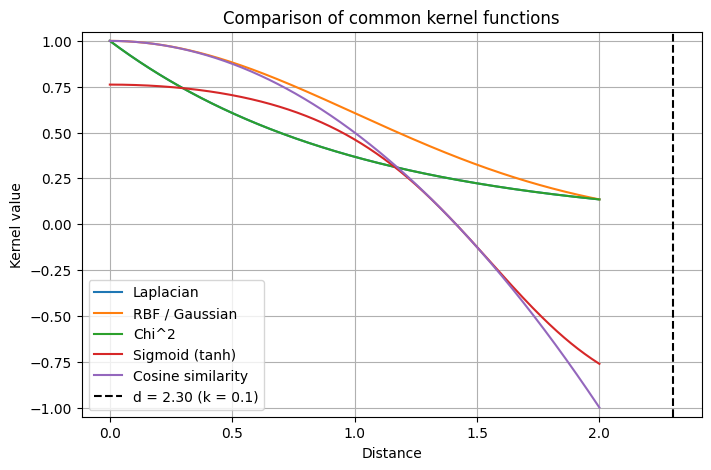

In [11]:
# Distance domain (0‒2 keeps the cosine/sigmoid well-defined)
d = np.linspace(0.0, 2.0, 500)

variance = 1.0            # Laplacian & RBF
# alpha     = 1.0           # Rational Quadratic shape
# length_sq = 1.0           # Rational Quadratic ℓ²
gamma     = 1.0           # chi sq

# Radial kernels
laplacian_vals = np.exp(-d / math.sqrt(variance))
rbf_vals       = np.exp(-d**2 / (2 * variance))
# rq_vals        = (1 + d**2 / 2.0)**-1       # alpha = 1, ℓ = 1
chi2_vals      = np.exp(-d)                 # γ = 1, using χ² distance = d

# Map Euclidean distance → dot product for unit-norm vectors
dot = 1 - d**2 / 2.0                        # ⟨x,y⟩ = cos θ
# sigmoid_vals = np.tanh(dot)                 # γ = 1, c = 0
# cosine_vals  = dot                          # cosine similarity itself

valid = dot >= -1.0                                # keep sigmoid/cosine valid
sigmoid_vals = np.where(valid, np.tanh(dot), np.nan)
cosine_vals  = np.where(valid, dot,       np.nan)



# Plot everything together
plt.figure(figsize=(8, 5))
plt.plot(d, laplacian_vals, label='Laplacian')
plt.plot(d, rbf_vals, label='RBF / Gaussian')
# plt.plot(d, rq_vals, label='Rational Quadratic')
plt.plot(d, chi2_vals, label='Chi^2')
plt.plot(d, sigmoid_vals, label='Sigmoid (tanh)')
plt.plot(d, cosine_vals, label='Cosine similarity')

# Plot line where laplacian reaches 0.1 since it is the fastest decaying kernel (most of the times)
threshold_val = 0.1
target_d = -math.log(threshold_val) * math.sqrt(variance)
plt.axvline(target_d, linestyle='--', color='k',
            label=f'd = {target_d:.2f} (k = {threshold_val})')

plt.xlabel('Distance')
plt.ylabel('Kernel value')
plt.title('Comparison of common kernel functions')
plt.ylim(-1.05, 1.05)
plt.legend()
plt.grid(True)
plt.show()